## Step 1. 

We'll use the Chest X-Ray Images (Pneumonia) dataset from Kaggle, which contains over 5,800 X-Ray images categorized into Pneumonia and Normal classes.

## Step 2.  Data Cleaning


For this dataset, we'll need to organize the images and ensure they're in a usable format.

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

def populate_validation_set(base_dir, val_ratio=0.2):
    for class_name in ['NORMAL', 'PNEUMONIA']:
        train_dir = os.path.join(base_dir, 'train', class_name)
        val_dir = os.path.join(base_dir, 'val', class_name)

        # Get all files in the train directory
        files = os.listdir(train_dir)

        # Split into new train and validation sets
        train_files, val_files = train_test_split(files, test_size=val_ratio, random_state=42)

        # Move validation files to the val directory
        for file in val_files:
            shutil.move(os.path.join(train_dir, file), os.path.join(val_dir, file))

        print(f"Moved {len(val_files)} files from {train_dir} to {val_dir}.")

base_dir = 'C:\\chest_xray'
train_dir ='C:\\chest_xray\\train'
val_dir = 'C:\\chest_xray\\val'
test_dir = 'C:\\chest_xray\\test'
populate_validation_set(base_dir)


Moved 137 files from C:\chest_xray\train\NORMAL to C:\chest_xray\val\NORMAL.
Moved 397 files from C:\chest_xray\train\PNEUMONIA to C:\chest_xray\val\PNEUMONIA.


## Step 3.  Data Exploration

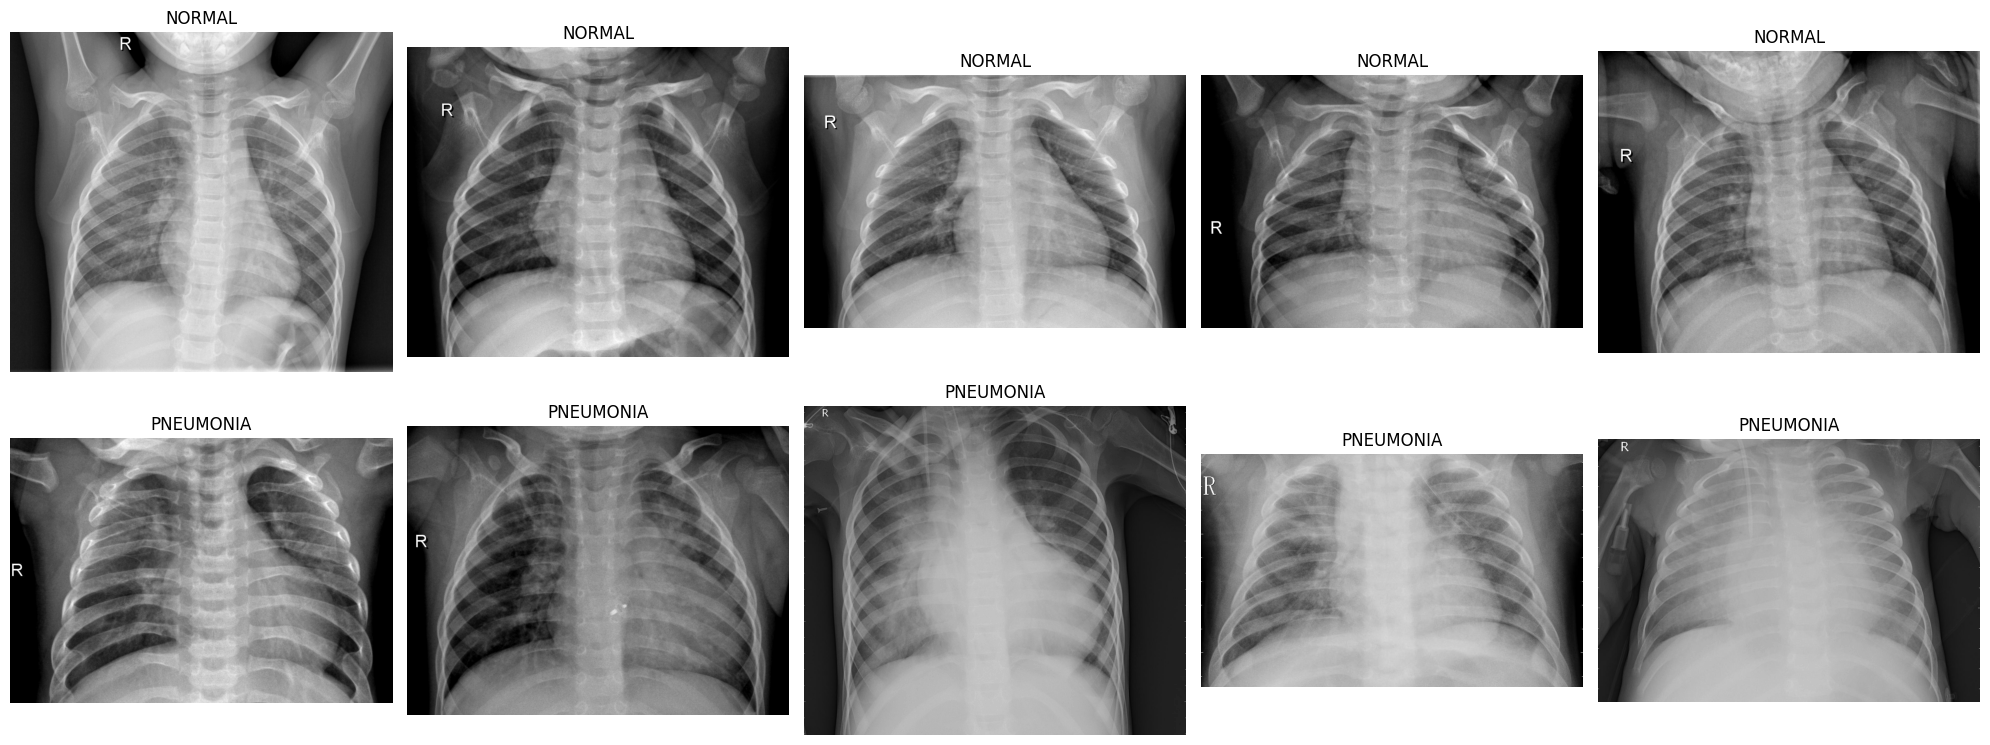

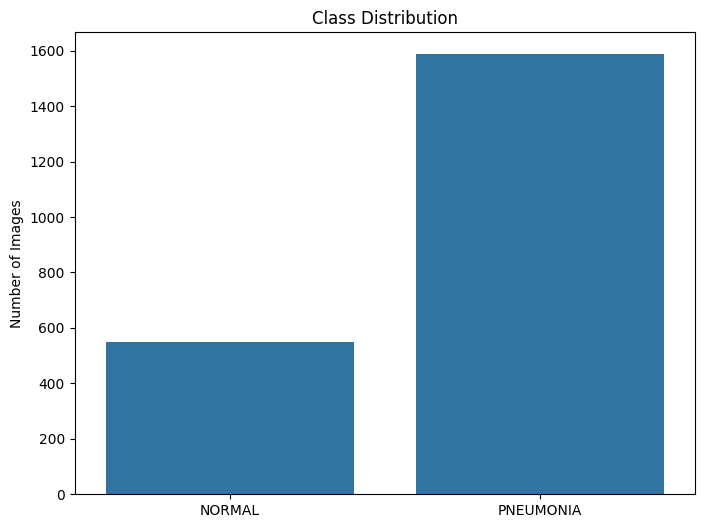

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

def plot_sample_images(data_dir, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    classes = ['NORMAL', 'PNEUMONIA']

    for i, cls in enumerate(classes):
        class_dir = os.path.join(data_dir, cls)
        img_files = os.listdir(class_dir)[:num_samples]
        for j, img_file in enumerate(img_files):
            img_path = os.path.join(class_dir, img_file)
            img = Image.open(img_path).convert('L')
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(cls)

    plt.tight_layout()
    plt.show()

def plot_class_distribution(data_dir):
    classes = ['NORMAL', 'PNEUMONIA']
    counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=classes, y=counts)
    plt.title('Class Distribution')
    plt.ylabel('Number of Images')
    plt.show()

plot_sample_images(train_dir)
plot_class_distribution(train_dir)

## Step 4.  Feature Engineering

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators(train_dir, val_dir, test_dir, batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )

    return train_generator, val_generator, test_generator

train_generator, val_generator, test_generator = create_data_generators(train_dir, val_dir, test_dir)

Found 2135 images belonging to 2 classes.
Found 2037 images belonging to 2 classes.
Found 1684 images belonging to 2 classes.


## Step 5.   Model Selection

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_transfer_learning_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()
transfer_model = create_transfer_learning_model()

# Train CNN model
cnn_history = cnn_model.fit(train_generator, epochs=20, validation_data=val_generator)

# Train Transfer Learning model
transfer_history = transfer_model.fit(train_generator, epochs=20, validation_data=val_generator)

# For traditional ML models, we need to extract features from images
def extract_features(generator):
    features = []
    labels = []
    for i in range(len(generator)):
        x, y = generator[i]
        features.append(x.reshape(x.shape[0], -1))
        labels.append(y)
    return np.concatenate(features), np.concatenate(labels)

train_features, train_labels = extract_features(train_generator)
val_features, val_labels = extract_features(val_generator)
test_features, test_labels = extract_features(test_generator)

# Train and evaluate traditional ML models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(train_features, train_labels)
    val_pred = model.predict(val_features)
    print(f"{name} Validation Accuracy: {accuracy_score(val_labels, val_pred)}")
    print(classification_report(val_labels, val_pred))

c:\Git\Xray_Neu\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Epoch 1/20


c:\Git\Xray_Neu\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7328 - loss: 0.6077 - val_accuracy: 0.7423 - val_loss: 0.5339
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 829ms/step - accuracy: 0.7507 - loss: 0.4980 - val_accuracy: 0.8100 - val_loss: 0.3852
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 58s 830ms/step - accuracy: 0.7665 - loss: 0.4217 - val_accuracy: 0.8827 - val_loss: 0.3257
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 843ms/step - accuracy: 0.7873 - loss: 0.4120 - val_accuracy: 0.8517 - val_loss: 0.3702
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 58s 831ms/step - accuracy: 0.7958 - loss: 0.3833 - val_accuracy: 0.9185 - val_loss: 0.2679
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 843ms/step - accuracy: 0.8140 - loss: 0.3443 - val_accuracy: 0.9298 - val_loss: 0.2857
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 833ms/step - accuracy: 0.8464 - loss: 0.3290 - val_accuracy: 0.9210 - val_loss: 0.2328
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 837ms/step - accuracy: 0.8487 - loss: 0.3171 - val_accuracy: 0.9033 

In [11]:
#lets see the model summary of all models

print(cnn_model.summary())
print(transfer_model.summary())



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,720,581 (14.19 MB)

 Trainable params: 1,240,193 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,480,388 (9.46 MB)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,007,685 (80.14 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 4,195,332 (16.00 MB)

None


## Step 6. Hyperparameter Tuning

In [7]:
from sklearn.model_selection import RandomizedSearchCV

# Example for Random Forest
param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_distributions=param_dist,
                               n_iter=20,
                               cv=3,
                               random_state=42,
                               n_jobs=-1)

rf_random.fit(train_features, train_labels)
print("Best hyperparameters:", rf_random.best_params_)

Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


## Step 7.  Pickle Files


In [12]:
import pickle

def save_model(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

save_model(cnn_model, 'cnn_model.h5')
save_model(transfer_model, 'transfer_model.h5')
save_model(rf_random.best_estimator_, 'rf_model.pkl')
save_model(models['SVM'], 'svm_model.pkl')
save_model(models['Gradient Boosting'], 'gb_model.pkl')     

## Step 8.  App.py Flask or Streamlit Web Application


## Step 9: GitHub Repository

In [ ]:
pneumonia-detection/
├── data/
│   ├── train/
│   ├── val/
│   └── test/
├── models/
│   ├── cnn_model.pkl
│   ├── transfer_model.pkl
│   ├── rf_model.pkl
│   ├── svm_model.pkl
│   └── gb_model.pkl
├── static/
│   └── style.css
├── templates/
│   └── index.html
├── app.py
├── data_preparation.py
├── model_training.py
├── requirements.txt
├── README.md
└── .gitignore

## Step 10: Cloud Deployment